In [1]:
from olfactometer_ingestion import create_device, populate_software_events
from pathlib import Path

import pandas as pd
import numpy as np
from scipy.integrate import simpson
import statistics as stats
from scipy.signal import find_peaks
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
TARGET_PATH = Path(r"C:\Users\huy.nguyen\Downloads\20240301T160321 1\20240301T160321")
OLFACTOMETER = create_device("Olfactometer")
ANALOG_INPUT = create_device("AnalogInput")
SOFTWARE_EVENTS = populate_software_events(root_path=TARGET_PATH)

In [3]:
endValve = OLFACTOMETER.EndValveState.read(TARGET_PATH/"Olfactometer.harp/Register__EndValveState.bin")
endValve.head(10)

,EndValve0,EndValve1,ValveDummy
Time,,,
681743.391488,False,False,False
681743.461504,False,False,False
681758.408480,True,False,False
681760.412480,False,False,False
681770.422496,True,False,False
681772.423488,False,False,False
681782.435488,True,False,False
681784.446496,False,False,False
681794.456480,True,False,False


In [4]:
analog = ANALOG_INPUT.AnalogData.read(TARGET_PATH/"AnalogInput.harp/Register__33.bin")["Channel0"]
analog.head(10)

Time
681742.376992    1673
681742.377984    1674
681742.378976    1676
681742.380000    1676
681742.380992    1670
681742.381984    1672
681742.382976    1670
681742.384000    1669
681742.384992    1672
681742.385984    1672
Name: Channel0, dtype: int16

In [5]:
SOFTWARE_EVENTS.keys()

dict_keys(['IsEndValveCalibration', 'OdorChannel', 'OdorConfig'])

In [6]:
odor_config = SOFTWARE_EVENTS["OdorConfig"]["data"]
odor_config = pd.DataFrame(odor_config.values.tolist(), index = odor_config.index)
odor_config = odor_config.iloc[:, 0:2]
odor_config

,channel_index,odorant
Seconds,,
681743.392000,2,AmylAcetate
681868.532992,1,AlphaPinene
681993.658976,0,Eugenol
682118.772992,2,AmylAcetate
682243.917984,1,AlphaPinene
682369.069984,0,Eugenol


In [7]:
cali_val = SOFTWARE_EVENTS['IsEndValveCalibration']['data']
cali_val = pd.DataFrame(cali_val.values.tolist(), index= cali_val.index)
cali_val = cali_val.iloc[:, 0]
cali_val

Seconds
681743.390976     True
681868.532992     True
681993.657984     True
682118.772992    False
682243.917984    False
682369.068992    False
Name: 0, dtype: bool

In [8]:
end_valve_open = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == 1.0]
end_valve_closed = endValve['EndValve0'].loc[endValve['EndValve0'].astype(float).diff() == -1.0]

print(f"end_valve_open | length: {len(end_valve_open)}\n{end_valve_open.head(5)}")
print()
print(f"end_valve_closed | length: {len(end_valve_closed)}\n{end_valve_closed.head(5)}")

end_valve_open | length: 33
Time
681758.408480    True
681770.422496    True
681782.435488    True
681794.456480    True
681806.473504    True
Name: EndValve0, dtype: bool

end_valve_closed | length: 32
Time
681760.412480    False
681772.423488    False
681784.446496    False
681796.458496    False
681808.474496    False
Name: EndValve0, dtype: bool


In [9]:
valve_status = pd.concat(
    [pd.DataFrame({'time_open' : end_valve_open.index}),
    pd.DataFrame({'time_closed': end_valve_closed.index})],
    ignore_index= True,
    axis= 1
).\
    rename(columns={0: 'time_valve_open', 1: 'time_valve_closed'})

valve_status = valve_status.fillna(max(analog.index))

In [10]:
analog.index = np.float64(analog.index)
nu_analog = analog[analog.index >= valve_status['time_valve_open'][0] - 1]

In [11]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [12]:
def extract_trial(type_val):
    big_list = []
    if type_val == 'data':
        for i in range(len(valve_status)):
            
            big_list.append(
                nu_analog.values[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 1)].tolist()
            )
            
    elif type_val == 'seconds':
        for i in range(len(valve_status)):
            
            big_list.append(
                nu_analog.index[(valve_status['time_valve_open'][i] - 1 <= nu_analog.index) & (nu_analog.index <= valve_status['time_valve_closed'][i] + 1)].tolist()
            )
    return big_list

In [13]:
valve_status['data'] = extract_trial('data')
valve_status['seconds'] = extract_trial('seconds')

In [14]:
def get_odor_list():
    odor_list = []
    index_pos = 0

    for i in valve_status['time_valve_open']:
        if odor_config.index[index_pos] <= i < odor_config.index[index_pos + 1]:
            odor_list.append(odor_config['odorant'].iloc[index_pos])
        elif i >= odor_config.index[index_pos + 1]:
            odor_list.append(odor_config['odorant'].iloc[index_pos + 1])
            index_pos += 1
    
    return odor_list

In [15]:
valve_status['odorant'] = get_odor_list()
valve_status = valve_status.merge(odor_config.iloc[0:3,:], on = 'odorant', how = 'left')

In [16]:
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[0], 'IsEndValveCalibration'] = True
valve_status.loc[valve_status['time_valve_open'] >= cali_val.index[3], 'IsEndValveCalibration'] = False

In [17]:
valve_status['trial_count'] = valve_status.groupby(['channel_index', 'IsEndValveCalibration']).cumcount() + 1

In [18]:
valve_status = valve_status[['IsEndValveCalibration', 'channel_index', 'odorant', 'trial_count', 'time_valve_open', 'time_valve_closed', 'seconds', 'data']]

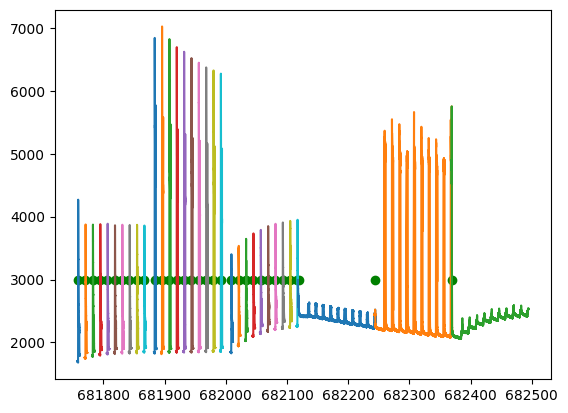

In [19]:
plt.figure()
for i, v in valve_status.iterrows():
    plt.plot(v['seconds'], v['data'])
    plt.scatter(v['time_valve_open'], 3000, color = 'g')
plt.show()

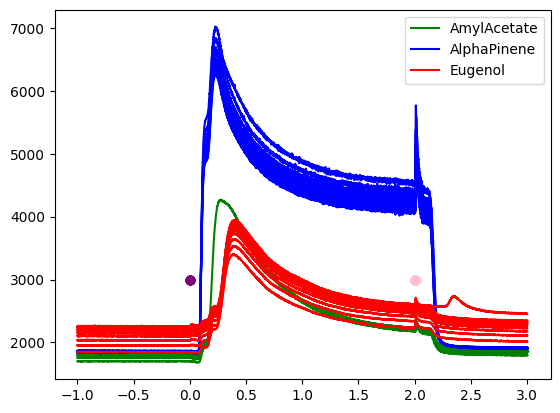

In [20]:
plt.figure()
for i, v in valve_status.iloc[0:30].iterrows():
    if v['channel_index'] == 0:
        col = 'r'
        lab = 'Eugenol'
    elif v['channel_index'] == 1:
        col = 'b'
        lab = 'AlphaPinene'
    else:
        col = 'g'
        lab = 'AmylAcetate'
    
    plt.plot([x - v['time_valve_open'] for x in v['seconds']], v['data'], color = col, label = lab)
    plt.scatter((v['time_valve_open'] - v['time_valve_open']), 3000, color = 'purple')
    plt.scatter((v['time_valve_closed'] - v['time_valve_open']), 3000, color = 'pink')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
    
plt.show()

### Interpolating data

In [21]:
valve_interpolate = valve_status[valve_status['IsEndValveCalibration'] == True]

In [22]:
def interpolate(inp, fi):
    i, f = int(fi // 1), fi % 1  # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * inp[i] + f * inp[j]

In [23]:
def interpolate_col(col_name, max_len):
    output = []
    
    for i in valve_interpolate[col_name]:
        inp = i
        delta = (len(inp) - 1) / (max_len - 1)
        output.append([interpolate(inp, j*delta) for j in range(max_len)])
    return output

In [24]:
outp = interpolate_col('data', 4011)
outp_time = interpolate_col('seconds', 4011)

In [25]:
valve_interpolate['data'] = outp
valve_interpolate['seconds'] = outp_time

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_3964\1615939181.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valve_interpolate['data'] = outp
C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_3964\1615939181.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valve_interpolate['seconds'] = outp_time


### Calculate mean group by odorant

In [26]:
valve_odo_mean = valve_interpolate[valve_interpolate['IsEndValveCalibration'] == True].\
    groupby(['channel_index', 'odorant'], as_index= False).\
        agg(
            mean_time_valve_open = ('time_valve_open', 'mean'),
            mean_time_valve_closed = ('time_valve_closed', 'mean')
        )

valve_odo_mean['mean_seconds'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['seconds'])], include_groups = False)
valve_odo_mean['mean_data'] = valve_interpolate.groupby('channel_index', group_keys = False).apply(lambda g: [np.mean(k) for k in zip(*g['data'])], include_groups = False)

In [27]:
def normalize_col():
    mean_seconds_norm = []
    mean_data_norm = []

    for i, v in valve_odo_mean.iterrows():
        mean_seconds_norm.append([x - v['mean_time_valve_open'] for x in v['mean_seconds']])
        mean_data_norm.append([x - v['mean_data'][0] for x in v['mean_data']])
    valve_odo_mean['mean_seconds_norm'] = mean_seconds_norm
    valve_odo_mean['mean_data_norm'] = mean_data_norm
    
    return valve_odo_mean

valve_odo_mean = normalize_col()
valve_odo_mean

,channel_index,odorant,mean_time_valve_open,mean_time_valve_closed,mean_seconds,mean_data,mean_seconds_norm,mean_data_norm
0,0,Eugenol,682062.726186,682064.727901,"[682061.7266912, 682061.7276840929, 682061.728...","[2124.3, 2124.300473815461, 2124.8961596009976...","[-0.9994943999918178, -0.9985015070997179, -0....","[0.0, 0.0004738154607366596, 0.596159600997452..."
1,1,AlphaPinene,681937.603789,681939.606096,"[681936.6042879999, 681936.605284232, 681936.6...","[1857.8, 1857.7008728179549, 1857.998204488778...","[-0.9995008000405505, -0.9985045680077747, -0....","[0.0, -0.09912718204509474, 0.1982044887779466..."
2,2,AmylAcetate,681812.475008,681814.477891,"[681811.475488, 681811.476484381, 681811.47748...","[1812.5, 1813.6979800498752, 1813.798503740648...","[-0.9995200000703335, -0.9985236190259457, -0....","[0.0, 1.197980049875241, 1.298503740648357, 0...."


### Graphing

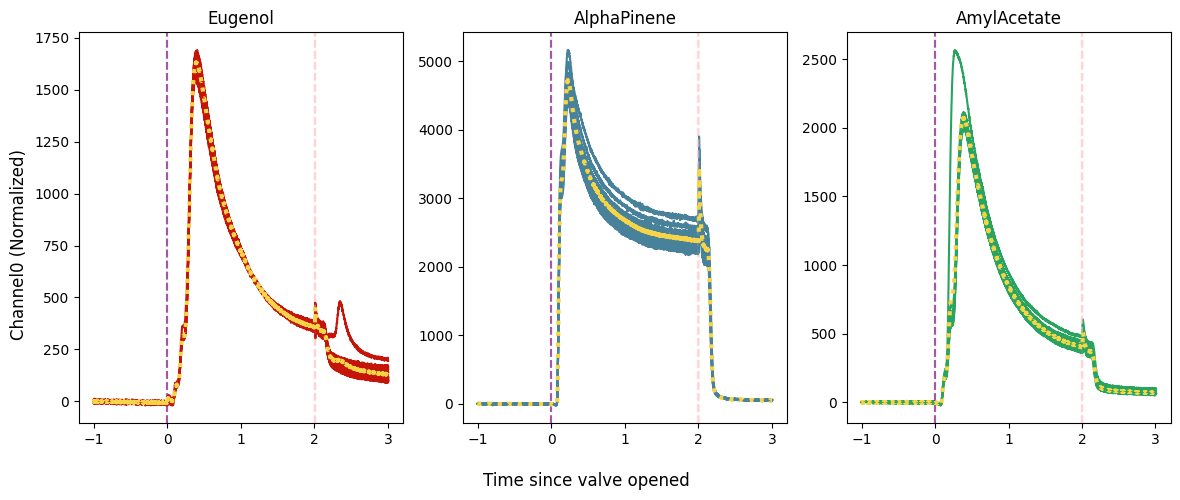

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 0)].iterrows():
    ax1.plot([x - v['time_valve_open'] for x in v['seconds']], [y - v['data'][0] for y in v['data']], color = '#C41508')
    ax1.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', alpha = .1)
    ax1.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', alpha = .1)
    ax1.set_title("Eugenol")
    
ax1.plot(valve_odo_mean['mean_seconds_norm'][0], valve_odo_mean['mean_data_norm'][0], color = '#F5D547', linestyle = 'dotted', linewidth = 3)    

for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 1)].iterrows():
    ax2.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#47829A')
    ax2.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', alpha = .1)
    ax2.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', alpha = .1)
    ax2.set_title("AlphaPinene")

ax2.plot(valve_odo_mean['mean_seconds_norm'][1], valve_odo_mean['mean_data_norm'][1], color = '#F5D547', linestyle = 'dotted', linewidth = 3)
    
for i, v in valve_interpolate[(valve_interpolate['channel_index'] == 2)].iterrows():
    ax3.plot([x - v['time_valve_open'] for x in v['seconds']],  [y - v['data'][0] for y in v['data']], color = '#28A460')
    ax3.axvline((v['time_valve_open'] - v['time_valve_open']), color = 'purple', linestyle = 'dashed', alpha = .1)
    ax3.axvline((v['time_valve_closed'] - v['time_valve_open']), color = 'pink', linestyle = 'dashed', alpha = .1)
    ax3.set_title("AmylAcetate")

ax3.plot(valve_odo_mean['mean_seconds_norm'][2], valve_odo_mean['mean_data_norm'][2], color = '#F5D547', linestyle = 'dotted', linewidth = 3)

fig.supxlabel('Time since valve opened')
fig.supylabel('Channel0 (Normalized)')
fig.set_figheight(5)
fig.set_figwidth(12)
fig.tight_layout()

In [29]:
valve_calTrue = valve_status[valve_status['IsEndValveCalibration'] == True]
valve_calTrue.head()

,IsEndValveCalibration,channel_index,odorant,trial_count,time_valve_open,time_valve_closed,seconds,data
0,True,2,AmylAcetate,1,681758.408480,681760.412480,"[681757.408992, 681757.409984, 681757.410976, ...","[1699, 1703, 1704, 1703, 1705, 1707, 1705, 170..."
1,True,2,AmylAcetate,2,681770.422496,681772.423488,"[681769.422976, 681769.424, 681769.424992, 681...","[1758, 1757, 1759, 1758, 1763, 1757, 1756, 175..."
2,True,2,AmylAcetate,3,681782.435488,681784.446496,"[681781.436, 681781.436992, 681781.437984, 681...","[1790, 1792, 1789, 1786, 1782, 1789, 1788, 178..."
3,True,2,AmylAcetate,4,681794.456480,681796.458496,"[681793.456992, 681793.457984, 681793.458976, ...","[1810, 1812, 1812, 1810, 1811, 1808, 1812, 181..."
4,True,2,AmylAcetate,5,681806.473504,681808.474496,"[681805.473984, 681805.474976, 681805.476, 681...","[1830, 1830, 1829, 1830, 1836, 1828, 1828, 182..."


### Calculate t-ON at quantile: .5, .75, .95, 1

In [30]:
def get_quantile(df):
    small_list = []
    output_list = []
    
    for i in range(len(df)):
        index_data = df['data'][i]
        index_sec = df['seconds'][i]
        max_val = max(index_data)
        
        time_at_max = index_sec[index_data.index(max_val)]
        
        for t in [.50, .75, .90, 1]:
            time_at_t = np.quantile(
                [j for j in index_sec \
                    if j >= df['time_valve_open'][i] and \
                        j <= time_at_max],
                
                t
            )
            
            small_list.append(time_at_t)
            
            if len(small_list) == 4:
                output_list.append(small_list)
                small_list = []
                
    return output_list

In [31]:
valve_calTrue.insert(valve_calTrue.shape[1], 't_ON_quantile', get_quantile(valve_calTrue), True) #order: .50 > .75 > .95 > 1

### Find point of 5x baseline SD

In [32]:
def fiveX_SD():
    output_list = []
    
    for i in range(len(valve_calTrue)):
        x = valve_calTrue['seconds'][i]
        y = valve_calTrue['data'][i]
        time_valve_on = valve_calTrue['time_valve_open'][i]
        
        df = pd.DataFrame({'y': y}, index = x)
        
        df_baseline = df[df.index <= time_valve_on]
        
        baseline_sd = stats.stdev(df_baseline['y'])
        threshold = 5 * baseline_sd
        
        win_size = int(len(df) * 10 / 100)
        
        sd_roll = df.rolling(win_size).std()
        
        for j in sd_roll.values:
            if j >= threshold:
                output_val = sd_roll.index[sd_roll['y'] == j[0]][0]
                output_list.append(output_val)
                
                break
    
    return output_list

In [33]:
valve_calTrue.insert(valve_calTrue.shape[1], "t_ON_5xSD", fiveX_SD(), True)

In [34]:
valve_calTrue['t_ON_5xSD'] = valve_calTrue['t_ON_5xSD'] - valve_calTrue['time_valve_open']

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_3964\817709216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valve_calTrue['t_ON_5xSD'] = valve_calTrue['t_ON_5xSD'] - valve_calTrue['time_valve_open']


### Calculate t-OFF

In [35]:
def fiveX_revSD():
    output_list = []
    
    for i in range(len(valve_calTrue)):
        x = valve_calTrue['seconds'][i]
        y = valve_calTrue['data'][i]
        time_valve_off = valve_calTrue['time_valve_closed'][i]
        
        df = pd.DataFrame({'y': y}, index = x)
        df = df[df.index >= time_valve_off]
        df_rev = df.iloc[::-1]
        
        win_size = int(len(df) * 10 / 100)
        df_roll = df_rev.rolling(win_size).std().dropna()
        
        baseline_sd = np.mean(df_roll.iloc[0:100])
        threshold = 5 * baseline_sd
        
        for j in df_roll.values:
            if j >= threshold:
                output_val = df_roll.index[df_roll['y'] == j[0]][0]
                output_list.append(output_val)
                
                break
    return output_list

In [36]:
valve_calTrue.insert(valve_calTrue.shape[1], 't_OFF_5xSD', fiveX_revSD(), True)

In [37]:
valve_calTrue['t_OFF_5xSD'] = valve_calTrue['t_OFF_5xSD'] - valve_calTrue['time_valve_closed']

C:\Users\huy.nguyen\AppData\Local\Temp\ipykernel_3964\2923537304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valve_calTrue['t_OFF_5xSD'] = valve_calTrue['t_OFF_5xSD'] - valve_calTrue['time_valve_closed']


In [38]:
counts_ON = valve_calTrue.groupby(['odorant', 't_ON_5xSD']).count()['data'].reset_index()
counts_ON

,odorant,t_ON_5xSD,data
0,AlphaPinene,0.086496,1
1,AlphaPinene,0.087488,1
2,AlphaPinene,0.087488,3
3,AlphaPinene,0.087520,2
4,AlphaPinene,0.087520,3
5,AmylAcetate,0.105504,1
6,AmylAcetate,0.105504,1
7,AmylAcetate,0.106496,2
8,AmylAcetate,0.107520,1
9,AmylAcetate,0.108416,1


[Text(0.5, 0, 't-on'), Text(0, 0.5, 'count')]

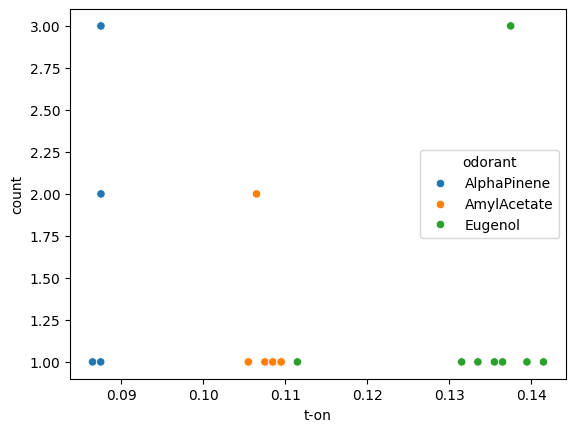

In [39]:
sns.scatterplot(x = 't_ON_5xSD', y = 'data', hue = 'odorant', data = counts_ON).set(xlabel = 't-on', ylabel = 'count')

In [40]:
counts_OFF = valve_calTrue.groupby(['odorant', 't_OFF_5xSD']).count()['data'].reset_index()
counts_OFF

,odorant,t_OFF_5xSD,data
0,AlphaPinene,0.237504,1
1,AlphaPinene,0.241472,1
2,AlphaPinene,0.246496,1
3,AlphaPinene,0.248480,1
4,AlphaPinene,0.248512,1
5,AlphaPinene,0.250496,1
6,AlphaPinene,0.253504,1
7,AlphaPinene,0.254496,1
8,AlphaPinene,0.257472,1
9,AlphaPinene,0.257504,1


[Text(0.5, 0, 't-off'), Text(0, 0.5, 'count')]

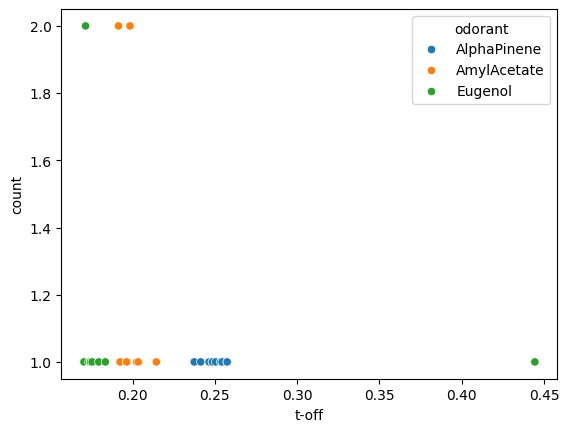

In [41]:
sns.scatterplot(x = 't_OFF_5xSD', y = 'data', hue = 'odorant', data = counts_OFF).set(xlabel = 't-off', ylabel = 'count')

### Calculate integral

In [42]:
def integral_simpson():
    output_list = []
    
    for i in range(len(valve_calTrue)):
        x_val = valve_calTrue['seconds'][i]
        y_val = valve_calTrue['data'][i]
        time_on = valve_calTrue['time_valve_open'][i]
        time_off = valve_calTrue['time_valve_closed'][i]
        
        df = pd.DataFrame({'y': y_val}, index = x_val)
        
        filtered_df = df['y'][(df.index >= time_on) & (df.index <= time_off)]
        
        simpson_val = simpson(y = filtered_df.values, x = filtered_df.index)
        
        output_list.append(simpson_val)
    
    return output_list

In [43]:
valve_calTrue.insert(valve_calTrue.shape[1], "integral_simpson", integral_simpson(), True)

array([[<Axes: title={'center': 'AlphaPinene'}>,
        <Axes: title={'center': 'AmylAcetate'}>],
       [<Axes: title={'center': 'Eugenol'}>, <Axes: >]], dtype=object)

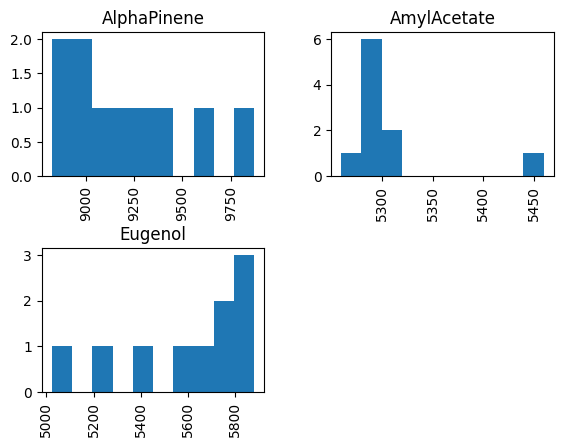

In [44]:
valve_calTrue.hist('integral_simpson', by = 'odorant')

In [45]:
valve_calTrue

,IsEndValveCalibration,channel_index,odorant,trial_count,time_valve_open,time_valve_closed,seconds,data,t_ON_quantile,t_ON_5xSD,t_OFF_5xSD,integral_simpson
0,True,2,AmylAcetate,1,681758.408480,681760.412480,"[681757.408992, 681757.409984, 681757.410976, ...","[1699, 1703, 1704, 1703, 1705, 1707, 1705, 170...","[681758.544, 681758.611488, 681758.652, 681758...",0.105504,0.214496,5459.209824
1,True,2,AmylAcetate,2,681770.422496,681772.423488,"[681769.422976, 681769.424, 681769.424992, 681...","[1758, 1757, 1759, 1758, 1763, 1757, 1756, 175...","[681770.614976, 681770.710976, 681770.7685952,...",0.105504,0.198496,5260.219041
2,True,2,AmylAcetate,3,681782.435488,681784.446496,"[681781.436, 681781.436992, 681781.437984, 681...","[1790, 1792, 1789, 1786, 1782, 1789, 1788, 178...","[681782.636, 681782.736, 681782.796, 681782.836]",0.106496,0.196480,5297.324032
3,True,2,AmylAcetate,4,681794.456480,681796.458496,"[681793.456992, 681793.457984, 681793.458976, ...","[1810, 1812, 1812, 1810, 1811, 1808, 1812, 181...","[681794.660992, 681794.762976, 681794.8241984,...",0.107520,0.203488,5298.313974
4,True,2,AmylAcetate,5,681806.473504,681808.474496,"[681805.473984, 681805.474976, 681805.476, 681...","[1830, 1830, 1829, 1830, 1836, 1828, 1828, 182...","[681806.669488, 681806.767232, 681806.8258848,...",0.106496,0.191488,5302.316333
5,True,2,AmylAcetate,6,681818.484576,681820.487488,"[681817.484992, 681817.485984, 681817.486976, ...","[1837, 1838, 1839, 1839, 1840, 1837, 1840, 183...","[681818.678976, 681818.776, 681818.8341824, 68...",0.108416,0.198496,5301.935167
6,True,2,AmylAcetate,7,681830.498496,681832.500480,"[681829.498976, 681829.5, 681829.500992, 68182...","[1843, 1847, 1843, 1848, 1847, 1843, 1843, 184...","[681830.6904800001, 681830.786232, 681830.8436...",0.108480,0.196512,5296.384595
7,True,2,AmylAcetate,8,681842.512480,681844.514496,"[681841.512992, 681841.513984, 681841.514976, ...","[1847, 1846, 1852, 1845, 1845, 1844, 1845, 185...","[681842.708992, 681842.806976, 681842.8657856,...",0.109504,0.202496,5294.350370
8,True,2,AmylAcetate,9,681854.524576,681856.526496,"[681853.524992, 681853.525984, 681853.526976, ...","[1853, 1853, 1856, 1849, 1849, 1848, 1849, 184...","[681854.7174879999, 681854.813736, 681854.8714...",0.109408,0.191488,5285.345976
9,True,2,AmylAcetate,10,681866.533504,681868.534496,"[681865.533984, 681865.534976, 681865.536, 681...","[1858, 1859, 1855, 1862, 1858, 1858, 1855, 185...","[681866.728992, 681866.82648, 681866.884992, 6...",0.109472,0.192480,5293.508611
